In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers,Model, Input

In [11]:
'''
Building the VAE(Variational Autoencoder), this network consist of 3 parts:
An encoder layer that turns a real image into a mean and a variance in a latent space
A sampling layer that takes  such mean and variance  and use them to sample random point from latent space
A decoder layer that turns points from the latent space back to into images
'''


#encoder layer
encoder_input=Input(shape=(28,28,1))
latent_dim=2
m=layers.Conv2D(32,3,activation='relu', strides=2, padding='same')(encoder_input)
m_1=layers.Conv2D(64,3, activation='relu', strides=2, padding='same')(m)
m_2=layers.Flatten()(m_1)
m_3=layers.Dense(16, activation='relu')(m_2)
z_mean=layers.Dense(latent_dim, name='z_mean')(m_3)
z_log_var=layers.Dense(latent_dim, name='z_log_var')(m_3)

encoder=keras.Model(encoder_input,[z_mean,z_log_var], name='encoder')

#Latent space sampling layer

class Sampler(layers.Layer):
    def call(self,z_mean,z_log_var):
        batch_size=tf.shape(z_mean)[0]
        z_size=tf.shape(z_mean)[1]
        epsilon=tf.random.normal(shape=(batch_size, z_size)) #generating a batch of normal random vectors
        return z_mean +tf.exp(0.5*z_log_var)*epsilon #applying the VAE Sampling formula



In [28]:
#decoder layer

latent_dim=2
latent_inputs=Input(shape=(latent_dim))
d=layers.Dense(7*7*64,activation='relu')(latent_inputs)
d_1=layers.Reshape((7,7,64))(d)
d_2=layers.Conv2DTranspose(64,3,activation='relu',strides=2, padding='same')(d_1)
d_3=layers.Conv2DTranspose(32,3, activation='relu', strides=2, padding='same')(d_2)
d_outputs=layers.Conv2D(1,3, activation='sigmoid', padding='same')(d_3)

decoder=keras.Model(latent_inputs,d_outputs,name='decoder')

        

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [15]:
#instatiating model on mnist dataset

(x_train, _),(x_test, _)=keras.datasets.mnist.load_data()
mnist_digits=np.concatenate([x_train,x_test], axis=0)
mnist_digits=np.expand_dims(mnist_digits, -1).astype("float32")/255





11501568/11490434 [==============================] - 0s 0us/step


In [41]:
vae=VAE(encoder, decoder)
vae.compile(
    optimizer=keras.optimizers.Adam(), run_eagerly=True
)
vae.fit(mnist_digits,epochs=20, batch_size=32)

Epoch 1/20
2188/2188 [==============================] - 88s 40ms/step - total_loss: 167.4873 - reconstruction_loss: 164.2731 - kl_loss: 3.2141
Epoch 2/20
2188/2188 [==============================] - 88s 40ms/step - total_loss: 154.1511 - reconstruction_loss: 150.7836 - kl_loss: 3.3676
Epoch 3/20
2188/2188 [==============================] - 87s 40ms/step - total_loss: 152.1205 - reconstruction_loss: 148.7232 - kl_loss: 3.3975
Epoch 4/20
2188/2188 [==============================] - 87s 40ms/step - total_loss: 151.0387 - reconstruction_loss: 147.6193 - kl_loss: 3.4191
Epoch 5/20
2188/2188 [==============================] - 86s 39ms/step - total_loss: 150.0903 - reconstruction_loss: 146.6602 - kl_loss: 3.4302
Epoch 6/20
2188/2188 [==============================] - 87s 40ms/step - total_loss: 149.3708 - reconstruction_loss: 145.8956 - kl_loss: 3.4752
Epoch 7/20
2188/2188 [==============================] - 87s 40ms/step - total_loss: 148.7601 - reconstruction_loss: 145.2622 - kl_loss: 3.4976

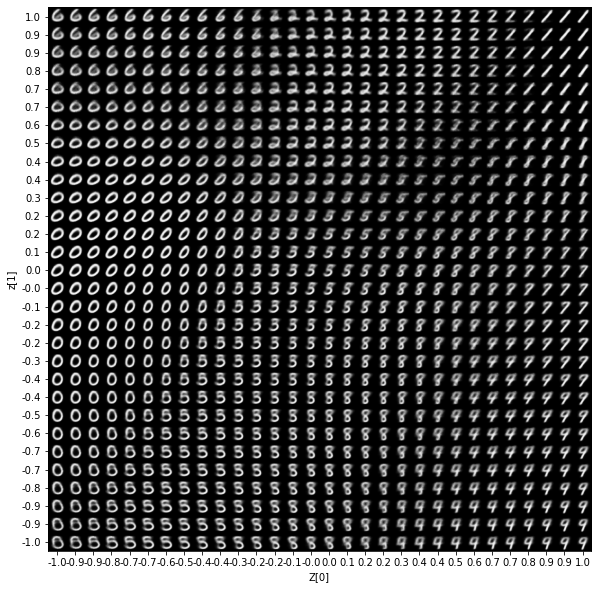

In [42]:
#sampling a grid of images
#generating 30*30 sample images

n=30
img_size=28
figure=np.zeros((img_size*n,img_size*n))

x_grid=np.linspace(-1,1,n)
y_grid=np.linspace(-1,1,n)[::-1]

for i, yi in enumerate(y_grid):
  for j,xi in enumerate(x_grid):
    z_sample=np.array([[xi,yi]])
    x_decoded=vae.decoder.predict(z_sample)
    img=x_decoded[0].reshape(img_size, img_size)

    figure[
           i * img_size: (i+1)*img_size,
           j* img_size: (j+1)*img_size,
    ]= img


plt.figure(figsize=(10,10))
start_range= img_size//2
end_range= n* img_size+ start_range

pix_range=np.arange(start_range, end_range, img_size)
x_sample_range=np.round(x_grid,1)
y_sample_range=np.round(y_grid,1)

plt.xticks(pix_range,x_sample_range)
plt.yticks(pix_range,y_sample_range)

plt.xlabel("Z[0]")
plt.ylabel("z[1]")

plt.imshow(figure, cmap='Greys_r')